In [100]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import FocalLoss, f1
from wrn4 import *

In [101]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN = Path('train/')

TRAIN64 = Path('train64/')
TRAIN128 = Path('train128/')
TRAIN256 = Path('train256/')
TEST256 = Path('test256/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

In [125]:
def open_image4d(fname:PathOrStr)->Image:
    '''open RGBA image from 4 different 1-channel files.
    return: numpy array [4, sz, sz]'''
    flags = cv2.IMREAD_GRAYSCALE
    red = cv2.imread(str((fname+ '_red.png')), flags)
    blue = cv2.imread(str((fname+ '_blue.png')), flags)
    green = cv2.imread(str((fname+ '_green.png')), flags)
    yellow = cv2.imread(str((fname+ '_yellow.png')),flags)
    im = np.stack(([red, green, blue, yellow]), axis=-1)

    return Image(Tensor(im).div_(255))

# def open_image4d(fn:PathOrStr)->Image:
#     "Return `Image` object created from image in file `fn`."
#     x = PIL.Image.open(fn)
#     return Image(pil2tensor(x).float().div_(255))

In [126]:
fname = str(TRAIN/'805b1562-bb9d-11e8-b2b9-ac1f6b6435d0')

In [127]:
%time x = open_image4d(fname)

CPU times: user 11 ms, sys: 255 µs, total: 11.2 ms
Wall time: 9.49 ms


In [131]:
x

TypeError: Invalid dimensions for image data

ValueError: Invalid dimensions, got (512, 4, 512)

Image (512, 512, 4)

In [106]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray]: return open_image4d(self.x[i]), self.encode(self.y[i])
    def _get_x(self,i): return open_image4d(self.x[i])

In [107]:
from fastai.data_block import _df_to_fns_labels
fnames, labels = _df_to_fns_labels(seg, suffix='.png', label_delim=' ', fn_col=0, label_col=1)
test_fnames, _ = _df_to_fns_labels(sample_sub, suffix='.png', fn_col=0, label_col=1)

In [108]:
classes = uniqueify(np.concatenate(labels))

In [109]:
stats = ([0.485, 0.456, 0.406, 0.406], [0.229, 0.224, 0.225, 0.225])
norm,denorm = normalize_funcs(*stats)

In [110]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [111]:
def get_data(sz=64, bs=64):
    folder=TRAIN
    test_ds=None
#     test_ds = Image4C_ds.from_single_folder(test_fnames, classes)
    train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=0.2, classes=classes)
    return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
                                 ds_tfms=tfms, tfms=norm, bs=bs, size=sz)

# def get_data(sz=64, bs=64):
#     test_ds=None
#     if sz==64: folder=TRAIN64
#     if sz==128: folder=TRAIN128
#     if sz==256: 
#         folder=TRAIN256
#         test_ds = Image4C_ds.from_single_folder(test_fnames, classes)
        
#     train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=0.2, classes=classes)
#     return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
#                                  ds_tfms=tfms, tfms=norm, bs=bs, size=sz)

In [112]:
# train, val = Image4C_ds.from_folder(PATH, TRAIN256, fnames, labels, valid_pct=0.2, classes=classes)

In [113]:
data64 = get_data(64, 128)

ValueError: not enough values to unpack (expected 3, got 1)

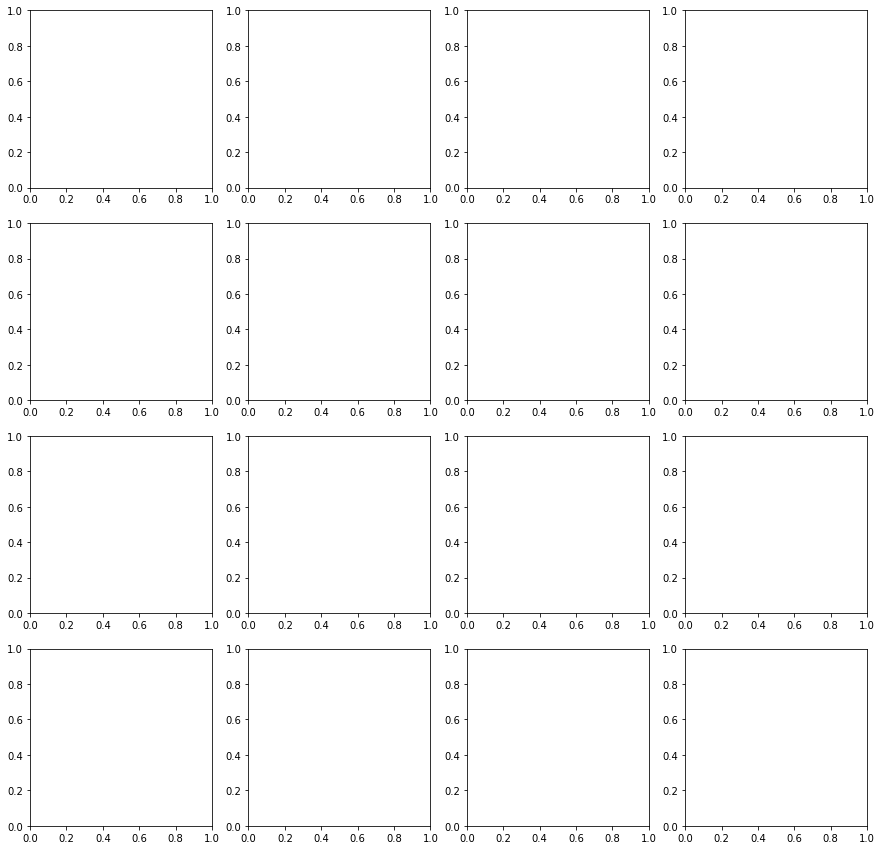

In [114]:
data64.show_batch(rows=4, figsize=(15,15))

In [13]:
# seg = pd.read_csv(PATH/MASKS)
# data64 = (ImageFileList.from_folder(PATH)
#         .label_from_df(seg, sep=' ', folder=TRAIN64, suffix='.png')  
#         .random_split_by_pct(0.2)
#         .datasets(Image4C_ds)  
#         .transform(tfms)             
#         .databunch()
#         .normalize(imagenet_stats))

In [14]:
arch = wrn_22_4()

In [25]:
def get_learner(data, loss=None, fp16=False):
    learn = Learner(data64, arch , metrics=[accuracy_thresh, f1])
    if loss: learn.loss_func=FocalLoss()
    if fp16: learn.to_fp16();
    return learn

In [97]:
%time learn.fit_one_cycle(10, 1e-2)

Total time: 17:22
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.965977    0.944407    0.956760         0.456077  (01:43)
2      0.951245    0.964348    0.956213         0.408621  (01:43)
3      0.955135    0.952904    0.956156         0.434715  (01:44)
4      0.942501    0.960163    0.955564         0.482579  (01:44)
5      0.921542    0.939348    0.957301         0.490238  (01:44)
6      0.916108    0.926019    0.957142         0.441561  (01:44)
7      0.896141    0.900398    0.958748         0.485665  (01:44)
8      0.879922    0.871664    0.960138         0.506264  (01:44)
9      0.872031    0.865757    0.960002         0.509077  (01:44)
10     0.872058    0.864252    0.960281         0.511381  (01:44)

CPU times: user 10min 46s, sys: 6min 28s, total: 17min 15s
Wall time: 17min 22s


In [98]:
learn.save('wrn4_64')

In [26]:
data = get_data(128, 48)
learn = get_learner(data, True, True)

In [27]:
learn.load('wrn4_64')

In [28]:
%time learn.fit_one_cycle(10, 1e-2/3)

Total time: 17:33
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      1.064508    1.009124    0.955522         0.458312  (01:44)
2      0.958235    0.971357    0.955713         0.461334  (01:44)
3      0.951486    1.060608    0.952314         0.391356  (01:44)
4      0.947318    1.003319    0.953134         0.379457  (01:45)
5      0.941754    0.975017    0.955435         0.446664  (01:45)
6      0.927451    0.959367    0.956146         0.462631  (01:45)
7      0.918070    0.932428    0.956823         0.438325  (01:45)
8      0.905158    0.921186    0.957568         0.466327  (01:45)
9      0.893581    0.921358    0.957794         0.473847  (01:45)
10     0.890840    0.917501    0.958083         0.477733  (01:45)

CPU times: user 10min 23s, sys: 6min 59s, total: 17min 22s
Wall time: 17min 33s


In [29]:
learn.save('wrn4_128')

In [ ]:
%time learn.fit_one_cycle(10, 1e-2/3)

epoch,train_loss,valid_loss,accuracy_thresh,f1
